# Alaska Airlines Data Science Interview Practical Exercise
#### Emily Yamauchi

## Table of Contents <a name="top"></a>

[Introduction](#introduction)  
[Step 0: Load data](#step0)  
[Step 1: Clean data](#step1)  
[Step 2: New Variables (Aircraft Age)](#step2)  
[Step 3: EDA](#step3)  
[Step 4: Preprocessing variables](#step4)  
[Step 5: Logistic Regression](#step5)  
[Step 6: Model Accuracy](#step6)  
[Step 7: Iterate through Steps 4-6](#step7)  
[Conclusion](#conclusion)

## Introduction <a name="introduction"></a>  

[(Back to top)](#top)

##### Background:   

Alaska Airlines takes great pride in being an on-time airline.  Systems operations wants predictions of flights that may be delayed as a part of a real time delay mitigation program, where crews may be asked to fly faster.  However, flying faster requires burning more fuel, so we don’t want to do it unless we need to do so to prevent an arrival delay.   We’ll want to provide a prediction at takeoff time for each flight.  Arrival-delayed flights are defined as flights that arrive at **14 minutes or more after the scheduled arrival time**. 

##### Data:  

The attached .csv file contains flight data from March 2020 to Feb 2021. Each row is a flight.  

- `OPER_CARR_CD`—Operating airline – AS = Alaska Airlines, QX = Horizon Airlines, OO = Skywest Airlines
- `ACT_ORIG`—Origin airport code
- `ACT_DEST`—Destination airport code			
- `FLT_NBR`—Flight number
- `ACT_FULL_TAIL_NBR`—Unique identifier for each individual aircraft
- `ACT_AC_TYPE` —Aircraft types with different performance and seat configuration –  
    Boeing 737, Airbus A320/321, De Havilland DH8-400, Embraer E175
- `SKD_MILES` —Number of flight miles between origin and destination
- `ACT_TAXI_OUT_MIN`—Minutes between gate departure and take off from runway at the origin
- `ACT_TAXI_IN_MIN`—Minutes between touch down onto runway and gate arrival at the destination
- `SKD_ZULU_DPTR_DTTM` —Scheduled departure datetime in UTC time
- `ACT_ZULU_DPTR_DTTM` —Actual departure datetime in UTC time
- `SKD_ZULU_ARRV_DTTM` —Scheduled arrival datetime in UTC time
- `ACT_ZULU_ARRV_DTTM` —Actual arrival datetime in UTC time
- `ACT_ORIG_GMT_OFFSET` —Time offset to convert from UTC time to the origin airport’s local time
- `ACT_DEST_GMT_OFFSET` —Time offset to convert from UTC time to the destination airport’s local time


## Step 0: Load libraries, load data  <a name="step0"></a>

[(Back to top)](#top)

- First, load the data given for this assessment
- The contents of the zip file given is saved in `data_raw/` directory

In [1]:
import pandas as pd
import numpy as np

In [2]:
# load data


df = pd.read_csv('data_raw/Predict Delays Mar 2020 to Feb 2021.csv')

In [3]:
# quick look at the data 

print('df.shape: ',df.shape)

df.shape:  (284555, 15)


In [4]:
df.describe()

,FLT_NBR,SKD_MILES,ACT_TAXI_OUT_MIN,ACT_TAXI_IN_MIN,ACT_ORIG_GMT_OFFSET,ACT_DEST_GMT_OFFSET
count,284555.000000,282049.000000,270281.000000,270274.000000,270284.000000,270279.000000
mean,2010.768909,890.703778,14.344612,5.879974,-7.261355,-7.261086
std,1745.855003,699.060577,6.901253,5.150821,1.015641,1.016000
min,1.000000,0.000000,-308.000000,-1432.000000,-10.000000,-10.000000
25%,678.000000,372.000000,10.000000,4.000000,-8.000000,-8.000000
50%,2102.000000,680.000000,13.000000,5.000000,-7.000000,-7.000000
75%,2807.000000,1133.000000,17.000000,7.000000,-7.000000,-7.000000
max,9999.000000,2899.000000,207.000000,217.000000,-4.000000,0.000000


## Step 1: Clean data  <a name="step1"></a>

[(Back to top)](#top)

- Convert data types as needed
- Extract `month` from the datetime column
    - In case flights straddle two months, the scheduled departure date will be kept as the `month` variable
- Create target variable for whether flight is delayed or not, per definition of 14 minutes past scheduled arrival
- Find and determine how to deal with missing data
- Find and determine how to deal with misleading data/outliers

In [5]:
# quick look at data types

for col in df.columns:
    print('Data type for column {} is {}'.format(col, type(df[col][0])))

Data type for column OPER_CARR_CD is <class 'str'>
Data type for column ACT_ORIG is <class 'str'>
Data type for column ACT_DEST is <class 'str'>
Data type for column FLT_NBR is <class 'numpy.int64'>
Data type for column ACT_FULL_TAIL_NBR is <class 'str'>
Data type for column ACT_AC_TYPE is <class 'str'>
Data type for column SKD_MILES is <class 'numpy.float64'>
Data type for column ACT_TAXI_OUT_MIN is <class 'numpy.float64'>
Data type for column ACT_TAXI_IN_MIN is <class 'numpy.float64'>
Data type for column SKD_ZULU_DPTR_DTTM is <class 'str'>
Data type for column ACT_ZULU_DPTR_DTTM is <class 'str'>
Data type for column SKD_ZULU_ARRV_DTTM is <class 'str'>
Data type for column ACT_ZULU_ARRV_DTTM is <class 'str'>
Data type for column ACT_ORIG_GMT_OFFSET is <class 'numpy.float64'>
Data type for column ACT_DEST_GMT_OFFSET is <class 'numpy.float64'>


In [6]:
# Datetime field is in string, so convert to datetime

from datetime import datetime, timedelta

dt_cols = ['SKD_ZULU_DPTR_DTTM', 'ACT_ZULU_DPTR_DTTM', 'SKD_ZULU_ARRV_DTTM', 'ACT_ZULU_ARRV_DTTM']


for dt_col in dt_cols:
    df[dt_col] = pd.to_datetime(df[dt_col])

In [7]:
# Extract month

df['month'] = df.SKD_ZULU_DPTR_DTTM.dt.month_name()

In [8]:
# Create target variable

delay = pd.to_timedelta(df.ACT_ZULU_ARRV_DTTM - df.SKD_ZULU_ARRV_DTTM)

delay_min = delay.dt.total_seconds() / 60 # minutes

delay_cutoff = 14  # given

df['delay_min'] = delay_min
df['is_delay'] = np.where(delay_min >= delay_cutoff, 1, -1)

In [9]:
# Find missing data per column

df.isnull().sum()

OPER_CARR_CD               0
ACT_ORIG                   0
ACT_DEST                   0
FLT_NBR                    0
ACT_FULL_TAIL_NBR          0
ACT_AC_TYPE                3
SKD_MILES               2506
ACT_TAXI_OUT_MIN       14274
ACT_TAXI_IN_MIN        14281
SKD_ZULU_DPTR_DTTM      4231
ACT_ZULU_DPTR_DTTM     14271
SKD_ZULU_ARRV_DTTM      4231
ACT_ZULU_ARRV_DTTM     14276
ACT_ORIG_GMT_OFFSET    14271
ACT_DEST_GMT_OFFSET    14276
month                   4231
delay_min              17344
is_delay                   0
dtype: int64

In [10]:
# Any column has missing data?

df_nulls = df.loc[df.isnull().any(axis=1)]

print("Missing data in any of the columns: ",df_nulls.shape)
print("Proportion of missing data to total dataset: ", df_nulls.shape[0]/df.shape[0])

Missing data in any of the columns:  (17350, 18)
Proportion of missing data to total dataset:  0.060972395494719826


There is quite a bit of missing data, and also some of the data points seems suspicious.  

##### Missing Data  

- `ACT_ZULU_ARRV_DTTM`: If the actual arrival time is missing, then there is no way of finding the target variable (determining whether the flight was delayed or not), so for the purpose of modeling flight delays, it would not make sense to include them.   
- `SKD_ZULU_ARRV_DTTM`: If the scheduled arrival time is missing, similarly it is difficult to determine whether the flight was delayed or not. One assumption that can be made is that scheduled flight time is consistent for the same flight numbers and/or same origin/destination pairs. If the flight time still cannot be determined, then there is no way to determine whether the flight was delayed or not, so those rows will be excluded.

(TBC...)

In [11]:
# First, exclude the rows where actual arrival time is missing
# Again- this is because without the actual arrival, there is no way of knowing whether the flight was delayed or not

df_clean = df.loc[df.ACT_ZULU_ARRV_DTTM.notnull()].reset_index(drop=True)

# Revist the missing data...

df_clean.isnull().sum()

OPER_CARR_CD              0
ACT_ORIG                  0
ACT_DEST                  0
FLT_NBR                   0
ACT_FULL_TAIL_NBR         0
ACT_AC_TYPE               0
SKD_MILES              1859
ACT_TAXI_OUT_MIN          7
ACT_TAXI_IN_MIN           5
SKD_ZULU_DPTR_DTTM     3068
ACT_ZULU_DPTR_DTTM        7
SKD_ZULU_ARRV_DTTM     3068
ACT_ZULU_ARRV_DTTM        0
ACT_ORIG_GMT_OFFSET       7
ACT_DEST_GMT_OFFSET       0
month                  3068
delay_min              3068
is_delay                  0
dtype: int64

##### Assumption: Flight times are consistent for the same flight number and/or destination/origin pairs

I will create a `df_schedule` table that will show the scheduled flight time for a given flight number/destination/origin combination, under the assumption that all of these flights will have consistent flight times.  

This will aid me in filling the `SKD_ARRV_DTTM` for flights that are missing that value.

In [12]:
# Flight number is NOT a unique identifier
# I.E. Flight Number 998

df_clean.loc[df_clean.FLT_NBR==998].ACT_ORIG.unique()

array(['PSP', 'ANC', 'SEA', 'SAN'], dtype=object)

In [13]:
# create a copy DataFrame of the Scheduled variables only

flight_cols = ['OPER_CARR_CD', 'ACT_ORIG', 'ACT_DEST', 'FLT_NBR','SKD_MILES', 'SKD_ZULU_DPTR_DTTM', 'SKD_ZULU_ARRV_DTTM']

flight_times = df_clean[flight_cols].copy()

# find the scheduled flight time based on the scheduled departure and arrival times

skd_flight_time = pd.to_timedelta(flight_times.SKD_ZULU_ARRV_DTTM - flight_times.SKD_ZULU_DPTR_DTTM)

flight_times['skd_flight_time'] = skd_flight_time.dt.total_seconds() / 60 # units = minutes

# drop the scheduled times in datetime

flight_times = flight_times.drop(columns=['SKD_ZULU_DPTR_DTTM', 'SKD_ZULU_ARRV_DTTM'])

flight_times.head()

,OPER_CARR_CD,ACT_ORIG,ACT_DEST,FLT_NBR,SKD_MILES,skd_flight_time
0,OO,SAN,SJC,3405,417.0,93.0
1,OO,OAK,PDX,3383,543.0,100.0
2,OO,SFO,SLC,3450,599.0,115.0
3,OO,SFO,SNA,3319,372.0,97.0
4,OO,STS,SAN,3379,509.0,95.0


In [14]:
# use the mean of the scheduled flight time

df_schedule = flight_times.groupby(['ACT_ORIG', 'ACT_DEST', 'SKD_MILES', 'FLT_NBR']).mean().reset_index()

# any still missing values?

df_schedule.isnull().sum()

ACT_ORIG             0
ACT_DEST             0
SKD_MILES            0
FLT_NBR              0
skd_flight_time    868
dtype: int64

There are still some missing values- I will perform a quick spot check to make sure that these flights are indeed ALL missing values in the original dataframe.  

In [15]:
# do a quick spot check- 
# see for SEA/PDX as that would seem to be a frequent flight
# find all the flight numbers to do spot check

df_schedule.loc[(df_schedule.skd_flight_time.isnull()) & 
                (df_schedule.ACT_ORIG=='SEA') & 
                (df_schedule.ACT_DEST=='PDX')].FLT_NBR.unique()

array([2181, 9565, 9740, 9741, 9743, 9791, 9801, 9802, 9804, 9806, 9809,
       9985, 9986, 9987, 9988, 9989, 9990, 9992, 9993, 9994, 9995, 9996,
       9998], dtype=int64)

In [16]:
# Are all the rows for this particular flight number/origin/destination missing scheduled time?

df.loc[(df.ACT_ORIG=='SEA') & (df.ACT_DEST=='PDX') & (df.FLT_NBR==9988)]

,OPER_CARR_CD,ACT_ORIG,ACT_DEST,FLT_NBR,ACT_FULL_TAIL_NBR,ACT_AC_TYPE,SKD_MILES,ACT_TAXI_OUT_MIN,ACT_TAXI_IN_MIN,SKD_ZULU_DPTR_DTTM,ACT_ZULU_DPTR_DTTM,SKD_ZULU_ARRV_DTTM,ACT_ZULU_ARRV_DTTM,ACT_ORIG_GMT_OFFSET,ACT_DEST_GMT_OFFSET,month,delay_min,is_delay
15249,QX,SEA,PDX,9988,451QX,DH8-400,NaN,13.0,9.0,NaT,2020-03-22 20:08:00,NaT,2020-03-22 20:59:00,-7.0,-7.0,NaN,NaN,-1
58992,QX,SEA,PDX,9988,401QX,DH8-400,0.0,13.0,8.0,NaT,2020-12-27 03:36:00,NaT,2020-12-27 04:27:00,-8.0,-8.0,NaN,NaN,-1
63118,QX,SEA,PDX,9988,630QX,E175,NaN,15.0,6.0,NaT,2020-03-15 05:55:00,NaT,2020-03-15 06:49:00,-7.0,-7.0,NaN,NaN,-1
84747,QX,SEA,PDX,9988,629QX,E175,0.0,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,-1
130383,QX,SEA,PDX,9988,450QX,DH8-400,0.0,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,-1
135836,QX,SEA,PDX,9988,628QX,E175,0.0,13.0,3.0,NaT,2021-01-15 16:58:00,NaT,2021-01-15 17:41:00,-8.0,-8.0,NaN,NaN,-1
152028,QX,SEA,PDX,9988,651QX,E175,0.0,14.0,4.0,NaT,2021-01-12 16:43:00,NaT,2021-01-12 17:31:00,-8.0,-8.0,NaN,NaN,-1
246056,QX,SEA,PDX,9988,436QX,DH8-400,NaN,13.0,4.0,NaT,2020-07-08 16:50:00,NaT,2020-07-08 17:45:00,-7.0,-7.0,NaN,NaN,-1


All of the flights for this given flight number/origin/departure combination are missing scheduled departure/arrival times.  

I could assume that all of the same origin/departure pairs have the same flight times, but absent an explicit definition I believe that would be too much of a leap- it could also be affected by time of day, etc.  

I am comfortable assuming that all the `NaN` values in `df_schedule` are indeed missing values, and will drop these from the schedule table.  
For the ones that have calculated `skd_flight_time` values, I will use that to compute `SKD_ZULU_ARRV_DTTM` in the cleaned table.

In [17]:
# drop the missing values

df_schedule_clean = df_schedule.loc[df_schedule.skd_flight_time.notnull()]

# any still missing?

df_schedule_clean.isnull().sum()

ACT_ORIG           0
ACT_DEST           0
SKD_MILES          0
FLT_NBR            0
skd_flight_time    0
dtype: int64

In [18]:
# first drop the scheduled miles as this will duplicate
df_schedule_clean_2 = df_schedule_clean.drop(columns=['SKD_MILES'])

# merge the scheduled flight time to the cleaned dataframe
df_clean_2 = df_clean.merge(df_schedule_clean_2, on = ['ACT_ORIG', 'ACT_DEST', 'FLT_NBR'])

# use the scheduled flight time to calculate scheduled arrival where it is missing
calc_arrv = pd.to_timedelta(df_clean_2.skd_flight_time, 'm') + df_clean_2.SKD_ZULU_DPTR_DTTM
df_clean_2.SKD_ZULU_ARRV_DTTM.fillna(calc_arrv, inplace=True)

# any still missing?
df_clean_2.isnull().sum()

OPER_CARR_CD             0
ACT_ORIG                 0
ACT_DEST                 0
FLT_NBR                  0
ACT_FULL_TAIL_NBR        0
ACT_AC_TYPE              0
SKD_MILES               86
ACT_TAXI_OUT_MIN         6
ACT_TAXI_IN_MIN          5
SKD_ZULU_DPTR_DTTM     108
ACT_ZULU_DPTR_DTTM       6
SKD_ZULU_ARRV_DTTM     108
ACT_ZULU_ARRV_DTTM       0
ACT_ORIG_GMT_OFFSET      6
ACT_DEST_GMT_OFFSET      0
month                  108
delay_min              108
is_delay                 0
skd_flight_time          0
dtype: int64

##### Missing data (cont.)  

Most of the missing values have been filled by the calculated flight times. The rest of the empty values are a very small portion of the entire dataset, so I am comfortable with just dropping these values.

In [19]:
# drop all remaining missing values
df_clean_3 = df_clean_2.dropna()

#review the current df
df_clean_3.describe()

,FLT_NBR,SKD_MILES,ACT_TAXI_OUT_MIN,ACT_TAXI_IN_MIN,ACT_ORIG_GMT_OFFSET,ACT_DEST_GMT_OFFSET,delay_min,is_delay,skd_flight_time
count,270255.000000,270255.000000,270255.000000,270255.000000,270255.000000,270255.000000,270255.000000,270255.000000,270255.000000
mean,1941.432099,893.855141,14.344652,5.870763,-7.266193,-7.264935,-5.590416,-0.792922,148.636736
std,1559.669366,693.848835,6.861962,4.341070,1.014387,1.016581,28.870612,0.609325,86.718737
min,1.000000,11.000000,-26.000000,-142.000000,-10.000000,-10.000000,-1241.000000,-1.000000,20.333333
25%,669.000000,376.000000,10.000000,4.000000,-8.000000,-8.000000,-18.000000,-1.000000,85.333333
50%,2101.000000,688.000000,13.000000,5.000000,-7.000000,-7.000000,-10.000000,-1.000000,128.289157
75%,2805.000000,1133.000000,17.000000,7.000000,-7.000000,-7.000000,0.000000,-1.000000,182.162011
max,9989.000000,2899.000000,207.000000,217.000000,-4.000000,-4.000000,758.000000,1.000000,427.833333


##### Suspicious Data?  

- Scheduled Miles: the minimum value is 11- is this correct? 
- Taxi minutes (both in and out): the minimum value is negative. As negative taxi minutes is nonsensical, these rows should be excluded.
- Any outliers in `delay_min`? Minimum value is almost 1 day (20 hours)

In [20]:
# negative taxi time?
neg_taxi = df_clean_3.loc[(df_clean_3.ACT_TAXI_IN_MIN < 0) | (df_clean_3.ACT_TAXI_OUT_MIN < 0)]
neg_taxi.head()

,OPER_CARR_CD,ACT_ORIG,ACT_DEST,FLT_NBR,ACT_FULL_TAIL_NBR,ACT_AC_TYPE,SKD_MILES,ACT_TAXI_OUT_MIN,ACT_TAXI_IN_MIN,SKD_ZULU_DPTR_DTTM,ACT_ZULU_DPTR_DTTM,SKD_ZULU_ARRV_DTTM,ACT_ZULU_ARRV_DTTM,ACT_ORIG_GMT_OFFSET,ACT_DEST_GMT_OFFSET,month,delay_min,is_delay,skd_flight_time
47722,OO,SEA,FAT,3490,174SY,E175,748.0,18.0,-142.0,2020-03-16 01:25:00,2020-03-16 01:17:00,2020-03-16 03:37:00,2020-03-16 01:19:00,-7.0,-7.0,March,-138.0,-1,127.095
99063,QX,SEA,BLI,2486,432QX,DH8-400,93.0,-26.0,4.0,2020-03-03 16:30:00,2020-03-03 16:20:00,2020-03-03 17:21:00,2020-03-03 16:21:00,-8.0,-8.0,March,-60.0,-1,51.000


In [21]:
# just two rows- believe it's safe to discard these
df_clean_4 = df_clean_3.drop(neg_taxi.index).reset_index(drop=True)

In [22]:
# scheduled miles- is 11 miles correct?
df_clean_4.loc[df_clean_4.SKD_MILES < 20]

,OPER_CARR_CD,ACT_ORIG,ACT_DEST,FLT_NBR,ACT_FULL_TAIL_NBR,ACT_AC_TYPE,SKD_MILES,ACT_TAXI_OUT_MIN,ACT_TAXI_IN_MIN,SKD_ZULU_DPTR_DTTM,ACT_ZULU_DPTR_DTTM,SKD_ZULU_ARRV_DTTM,ACT_ZULU_ARRV_DTTM,ACT_ORIG_GMT_OFFSET,ACT_DEST_GMT_OFFSET,month,delay_min,is_delay,skd_flight_time
125464,AS,OAK,SFO,9717,284AK,737-900R,11.0,20.0,5.0,2020-03-12 02:10:00,2020-03-12 02:49:00,2020-03-12 03:10:00,2020-03-12 03:34:00,-7.0,-7.0,March,24.0,1,60.0
125465,AS,OAK,SFO,9717,287AK,737-900R,11.0,11.0,10.0,2020-03-11 02:30:00,2020-03-11 04:14:00,2020-03-11 03:30:00,2020-03-11 04:45:00,-7.0,-7.0,March,75.0,1,60.0
125466,AS,OAK,SFO,9717,440AS,737-900E,11.0,21.0,10.0,2020-03-05 03:30:00,2020-03-05 03:47:00,2020-03-05 04:30:00,2020-03-05 04:33:00,-8.0,-8.0,March,3.0,-1,60.0
149596,AS,SFO,OAK,9716,493AS,737-900E,11.0,28.0,5.0,2020-03-03 15:45:00,2020-03-03 17:44:00,2020-03-03 16:30:00,2020-03-03 18:27:00,-8.0,-8.0,March,117.0,1,45.0


11 miles seemed to be a very short flight, but apparently there are flights between San Francisco and Oakland! 

In [23]:
# look at delay_min outliers

thres = 5 # hours
outlier_thres = thres * 60 # convert to min

df_clean_4.loc[df_clean_4.delay_min < -outlier_thres] # first see the flights that are 5 hours EARLY

,OPER_CARR_CD,ACT_ORIG,ACT_DEST,FLT_NBR,ACT_FULL_TAIL_NBR,ACT_AC_TYPE,SKD_MILES,ACT_TAXI_OUT_MIN,ACT_TAXI_IN_MIN,SKD_ZULU_DPTR_DTTM,ACT_ZULU_DPTR_DTTM,SKD_ZULU_ARRV_DTTM,ACT_ZULU_ARRV_DTTM,ACT_ORIG_GMT_OFFSET,ACT_DEST_GMT_OFFSET,month,delay_min,is_delay,skd_flight_time
56503,AS,SEA,ANC,105,457AS,737-900E,1448.0,16.0,4.0,2020-08-31 01:30:00,2020-08-30 04:16:00,2020-08-31 04:52:00,2020-08-30 08:11:00,-7.0,-8.0,August,-1241.0,-1,213.370166
92345,AS,SJO,LIR,299,587AS,737-800E,2729.0,43.0,3.0,2020-03-10 16:05:00,2020-03-10 16:08:00,2020-03-10 22:38:00,2020-03-10 17:19:00,-6.0,-6.0,March,-319.0,-1,390.800000
92346,AS,SJO,LIR,299,517AS,737-800E,2729.0,20.0,8.0,2020-03-12 16:05:00,2020-03-12 15:54:00,2020-03-12 22:38:00,2020-03-12 16:45:00,-6.0,-6.0,March,-353.0,-1,390.800000
92347,AS,SJO,LIR,299,592AS,737-800E,2729.0,12.0,3.0,2020-03-07 17:05:00,2020-03-07 16:56:00,2020-03-07 23:38:00,2020-03-07 17:35:00,-6.0,-6.0,March,-363.0,-1,390.800000
92348,AS,SJO,LIR,299,519AS,737-800E,2729.0,14.0,4.0,2020-03-08 16:05:00,2020-03-08 16:04:00,2020-03-08 22:38:00,2020-03-08 16:47:00,-6.0,-6.0,March,-351.0,-1,390.800000
92349,AS,SJO,LIR,299,536AS,737-800E,2729.0,19.0,3.0,2020-03-01 17:05:00,2020-03-01 16:44:00,2020-03-01 23:38:00,2020-03-01 17:28:00,-6.0,-6.0,March,-370.0,-1,390.800000
92350,AS,SJO,LIR,299,434AS,737-900E,2729.0,11.0,2.0,2020-03-03 17:05:00,2020-03-03 16:48:00,2020-03-03 23:38:00,2020-03-03 17:25:00,-6.0,-6.0,March,-373.0,-1,390.800000
92351,AS,SJO,LIR,299,587AS,737-800E,2729.0,8.0,5.0,2020-03-05 17:05:00,2020-03-05 16:52:00,2020-03-05 23:38:00,2020-03-05 17:23:00,-6.0,-6.0,March,-375.0,-1,390.800000
92352,AS,SJO,LIR,299,538AS,737-800E,2729.0,18.0,4.0,2020-03-17 16:05:00,2020-03-17 15:59:00,2020-03-17 22:38:00,2020-03-17 16:45:00,-6.0,-6.0,March,-353.0,-1,390.800000
92353,AS,SJO,LIR,299,535AS,737-800E,2729.0,16.0,4.0,2021-02-17 15:15:00,2021-02-17 14:58:00,2021-02-17 21:37:00,2021-02-17 15:41:00,-6.0,-6.0,February,-356.0,-1,390.800000


There seems to be something wrong with the SJO-LIR flights- the 'actual' flight time doesn't seem to be enough. It is difficult to determine what kind of an error is going on here, so I will create a column for `act_flight_time` and look at the variance between that and the scheduled flight time.

In [24]:
# calculate actual flight time 

act_flight_dt = df_clean_4.ACT_ZULU_ARRV_DTTM - df_clean_4.ACT_ZULU_DPTR_DTTM
act_flight_min = act_flight_dt.dt.total_seconds() / 60 # minutes

# look at the variance 

act_speed = (act_flight_min / 60) / df_clean_4.SKD_MILES # mph
skd_speed = (df_clean_4.skd_flight_time / 60) / df_clean_4.SKD_MILES # mph

speed_diff = act_speed - skd_speed
temp = pd.DataFrame(data={'act_speed':act_speed, 'skd_speed':skd_speed})

pct_diff = speed_diff/temp.min(axis=1)
pct_diff.describe()

count    270253.000000
mean         -0.036270
std           0.190520
min         -11.606452
25%          -0.097207
50%          -0.039668
75%           0.016692
max           3.819672
dtype: float64

While it's possible that a flight takes 4 times as long due to long delays, I find it unlikely that a flight travels 11.5 times faster than scheduled, so these data points seem suspicious.  

<AxesSubplot:>

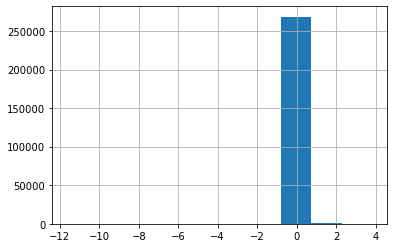

In [25]:
# quick visualization 
pct_diff.hist()

In [26]:
# what flights are twice as fast as scheduled?

df_clean_4.loc[pct_diff < -1].describe()

,FLT_NBR,SKD_MILES,ACT_TAXI_OUT_MIN,ACT_TAXI_IN_MIN,ACT_ORIG_GMT_OFFSET,ACT_DEST_GMT_OFFSET,delay_min,is_delay,skd_flight_time
count,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000
mean,6542.305955,406.572895,12.006160,4.320329,-8.160164,-8.162218,-11.133470,-0.412731,171.280034
std,1627.448256,536.300483,6.482801,2.481217,0.739129,0.726037,78.759157,0.911790,51.300739
min,23.000000,93.000000,2.000000,2.000000,-9.000000,-9.000000,-375.000000,-1.000000,94.000000
25%,7005.000000,95.000000,7.000000,3.000000,-9.000000,-9.000000,-23.000000,-1.000000,147.000000
50%,7005.000000,95.000000,11.000000,4.000000,-8.000000,-8.000000,-6.000000,-1.000000,147.000000
75%,7096.000000,571.000000,15.000000,5.000000,-8.000000,-8.000000,19.500000,1.000000,211.000000
max,9661.000000,2729.000000,43.000000,46.000000,-4.000000,-4.000000,245.000000,1.000000,410.000000


These nearly 500 rows seem suspicious- I find it unlikely that a flight will travel twice the normally scheduled speed, so I will exclude these from the dataset.

In [27]:
df_clean_5 = df_clean_4.drop(df_clean_4.loc[pct_diff < -1].index).reset_index(drop=True)

df_clean_5.describe()

,FLT_NBR,SKD_MILES,ACT_TAXI_OUT_MIN,ACT_TAXI_IN_MIN,ACT_ORIG_GMT_OFFSET,ACT_DEST_GMT_OFFSET,delay_min,is_delay,skd_flight_time
count,269766.000000,269766.000000,269766.000000,269766.000000,269766.000000,269766.000000,269766.000000,269766.000000,269766.000000
mean,1933.118529,894.738325,14.349010,5.874117,-7.264577,-7.263313,-5.579717,-0.793606,148.596301
std,1547.227576,693.793074,6.861501,4.333883,1.014107,1.016318,28.700461,0.608433,86.764425
min,1.000000,11.000000,1.000000,1.000000,-10.000000,-10.000000,-1241.000000,-1.000000,20.333333
25%,668.000000,376.000000,10.000000,4.000000,-8.000000,-8.000000,-18.000000,-1.000000,85.228571
50%,2100.000000,688.000000,13.000000,5.000000,-7.000000,-7.000000,-10.000000,-1.000000,128.000000
75%,2796.000000,1133.000000,17.000000,7.000000,-7.000000,-7.000000,0.000000,-1.000000,182.162011
max,9989.000000,2899.000000,207.000000,217.000000,-4.000000,-4.000000,758.000000,1.000000,427.833333


There also seems to be flights where the scheduled flight and actual flight day seems to be mismatched- while it is possible for that to happen due to a delay, if the flight is leaving another day early, that could be an input error.  

The previous step caught ones where the arrival time did not match, but if the speed is reasonable, these outliers were not caught.  

In [28]:
# threshold

df_clean_5.loc[df_clean_5.delay_min < -outlier_thres]

,OPER_CARR_CD,ACT_ORIG,ACT_DEST,FLT_NBR,ACT_FULL_TAIL_NBR,ACT_AC_TYPE,SKD_MILES,ACT_TAXI_OUT_MIN,ACT_TAXI_IN_MIN,SKD_ZULU_DPTR_DTTM,ACT_ZULU_DPTR_DTTM,SKD_ZULU_ARRV_DTTM,ACT_ZULU_ARRV_DTTM,ACT_ORIG_GMT_OFFSET,ACT_DEST_GMT_OFFSET,month,delay_min,is_delay,skd_flight_time
56503,AS,SEA,ANC,105,457AS,737-900E,1448.0,16.0,4.0,2020-08-31 01:30:00,2020-08-30 04:16:00,2020-08-31 04:52:00,2020-08-30 08:11:00,-7.0,-8.0,August,-1241.0,-1,213.370166
161559,OO,LAX,SLC,3465,198SY,E175,590.0,23.0,14.0,2020-12-31 22:40:00,2020-12-31 16:49:00,2021-01-01 00:38:00,2020-12-31 18:56:00,-8.0,-7.0,December,-342.0,-1,115.783784
269670,QX,PAE,SEA,9989,647QX,E175,32.0,16.0,4.0,2020-05-15 04:40:00,2020-05-14 20:40:00,2020-05-15 05:10:00,2020-05-14 21:10:00,-7.0,-7.0,May,-480.0,-1,30.000000


In [29]:
# also drop these rows

df_clean_6 = df_clean_5.drop(df_clean_5.loc[df_clean_5.delay_min < -outlier_thres].index).reset_index(drop=True)

In [30]:
# save intermediate file

df_clean_6.to_csv('data_clean/flights_cleaned.csv', index=False)

## Step 2: New Variables (Aircraft Age) <a name="step2"></a>

[(Back to top)](#top)

- As mentioned above, the tail number is a non-unique identifier variable without much insight
- However, it can be used to retreieve aircraft age, which may be a factor in the delay prediction model
- I downloaded the aircraft registration archive file from [FAA](https://www.faa.gov/licenses_certificates/aircraft_certification/aircraft_registry/releasable_aircraft_download/)- specifically, the `2020 Aircraft Registration Database`

In [31]:
# load more libraries

from zipfile import ZipFile
import os

In [32]:
# open files 

os.chdir('data_raw')

with ZipFile('ReleasableAircraft.2020.zip') as zipfiles:
    zipfiles.extractall()
    
os.chdir('..')

os.getcwd()

'C:\\Users\\admin\\Documents\\Job Search\\Summer 2021\\Technical\\Alaska Airlines\\Alaska Airline DS Interview'

In [33]:
# load the data- this is unzipped in the data_raw folder

aircrafts = pd.read_csv('data_raw/MASTER.txt')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [34]:
# load the cleaned flights dataset

flights = pd.read_csv('data_clean/flights_cleaned.csv')

In [35]:
# what are the variables?

aircrafts.columns

Index(['N-NUMBER', 'SERIAL NUMBER', 'MFR MDL CODE', 'ENG MFR MDL', 'YEAR MFR',
       'TYPE REGISTRANT', 'NAME', 'STREET', 'STREET2', 'CITY', 'STATE',
       'ZIP CODE', 'REGION', 'COUNTY', 'COUNTRY', 'LAST ACTION DATE',
       'CERT ISSUE DATE', 'CERTIFICATION', 'TYPE AIRCRAFT', 'TYPE ENGINE',
       'STATUS CODE', 'MODE S CODE', 'FRACT OWNER', 'AIR WORTH DATE',
       'OTHER NAMES(1)', 'OTHER NAMES(2)', 'OTHER NAMES(3)', 'OTHER NAMES(4)',
       'OTHER NAMES(5)', 'EXPIRATION DATE', 'UNIQUE ID', 'KIT MFR',
       ' KIT MODEL', 'MODE S CODE HEX', 'Unnamed: 34'],
      dtype='object')

In [36]:
# merge with unique aircrafts from flights table

aircraft_select = aircrafts[['N-NUMBER', 'NAME', 'YEAR MFR', 'CERT ISSUE DATE']]

aircraft_age = aircraft_select.merge(
    flights[['ACT_FULL_TAIL_NBR']], left_on='N-NUMBER', right_on='ACT_FULL_TAIL_NBR').drop_duplicates().reset_index(drop=True)

# convert to int 

aircraft_age['YEAR MFR'] = aircraft_age['YEAR MFR'].replace(r'^\s+$', 0, regex=True)
aircraft_age['YEAR MFR'] = aircraft_age['YEAR MFR'].astype(int)

In [37]:
# check if the owner names makes sense

aircraft_age.NAME.unique()

array(['SKYWEST AIRLINES INC                              ',
       'ALASKA AIRLINES INC                               ',
       'WELLS FARGO TRUST CO NA TRUSTEE                   ',
       'ALC A320 7138 LLC                                 ',
       'BCC EQUIPMENT LEASING CORP                        ',
       'HORIZON AIR INDUSTRIES INC                        ',
       'BANK OF UTAH TRUSTEE                              ',
       'WILMINGTON TRUST CO TRUSTEE                       ',
       'N524VA TRUST                                      ',
       'UMB BANK NA TRUSTEE                               ',
       'SASOF III 3445 OWNER STATUTORY TRUST              ',
       'CLASKA AIRLINES INC                               ',
       'JET-I 2616 OWNER TRUST                            ',
       'AFS INVESTMENTS 48 LLC                            ',
       'JET-I 2740 OWNER TRUST                            ',
       'AFS INVESTMENTS 67 LLC                            ',
       'SPIREDELL TRUST 

In [38]:
# missing values

aircraft_age.loc[aircraft_age['YEAR MFR']==0]

,N-NUMBER,NAME,YEAR MFR,CERT ISSUE DATE,ACT_FULL_TAIL_NBR
35,251AK,ALASKA AIRLINES INC ...,0,20160714,251AK
116,432QX,HORIZON AIR INDUSTRIES INC ...,0,20070731,432QX
186,527AS,ALASKA AIRLINES INC ...,0,20090526,527AS
305,841VA,WELLS FARGO TRUST CO NA TRUSTEE ...,0,20160825,841VA


In [39]:
# use certificate date as proxy if manufacture date is missing

aircraft_age['CERT YEAR'] = aircraft_age['CERT ISSUE DATE'].str[:-4].astype(int)

aircraft_age['year_mfr'] = np.where(aircraft_age['YEAR MFR']==0, aircraft_age['CERT YEAR'], aircraft_age['YEAR MFR'])

In [40]:
# need to convert again to datetime

dt_cols = ['SKD_ZULU_DPTR_DTTM', 'ACT_ZULU_DPTR_DTTM', 'SKD_ZULU_ARRV_DTTM', 'ACT_ZULU_ARRV_DTTM']


for dt_col in dt_cols:
    flights[dt_col] = pd.to_datetime(flights[dt_col])

In [41]:
# merge with the flights table
# get aircraft age

flights2 = flights.merge(aircraft_age[['ACT_FULL_TAIL_NBR', 'year_mfr']])

flights2['ac_age'] = flights2.ACT_ZULU_DPTR_DTTM.dt.year - flights2.year_mfr

In [42]:
# save again

flights2.to_csv('data_clean/flights_cleaned_new.csv', index=False)

## Step 3: EDA  <a name="step3"></a>

[(Back to top)](#top)

- Visualize distribution of variables
- Visualize relationship between variables
- Are there variables that can be taken out of the model?

In [43]:
# Load more libraries

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [44]:
# load cleaned data again

flights = pd.read_csv('data_clean/flights_cleaned_new.csv')

print('flights.shape: ', flights.shape)

flights.shape:  (269763, 21)


In [45]:
# revisit- what are the variables?

flights.columns

Index(['OPER_CARR_CD', 'ACT_ORIG', 'ACT_DEST', 'FLT_NBR', 'ACT_FULL_TAIL_NBR',
       'ACT_AC_TYPE', 'SKD_MILES', 'ACT_TAXI_OUT_MIN', 'ACT_TAXI_IN_MIN',
       'SKD_ZULU_DPTR_DTTM', 'ACT_ZULU_DPTR_DTTM', 'SKD_ZULU_ARRV_DTTM',
       'ACT_ZULU_ARRV_DTTM', 'ACT_ORIG_GMT_OFFSET', 'ACT_DEST_GMT_OFFSET',
       'month', 'delay_min', 'is_delay', 'skd_flight_time', 'year_mfr',
       'ac_age'],
      dtype='object')

In [46]:
# helper function

def get_pct_groupby(col):
    
    num = flights.loc[flights.is_delay==1].groupby(col).count()['is_delay']
    denom = flights.groupby(col).count()['is_delay']
    
    return num/denom

In [47]:
get_pct_groupby('OPER_CARR_CD')

OPER_CARR_CD
AS    0.123615
OO    0.070018
QX    0.090901
Name: is_delay, dtype: float64

In [48]:
# total delayed flights?

flights.loc[flights.is_delay==1].shape[0]/flights.shape[0]

0.10319799231176996

array([[<AxesSubplot:title={'center':'SKD_MILES'}>]], dtype=object)

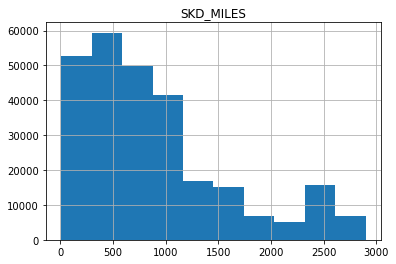

In [49]:
# distribution of variables- scheduled miles?

flights.hist('SKD_MILES')

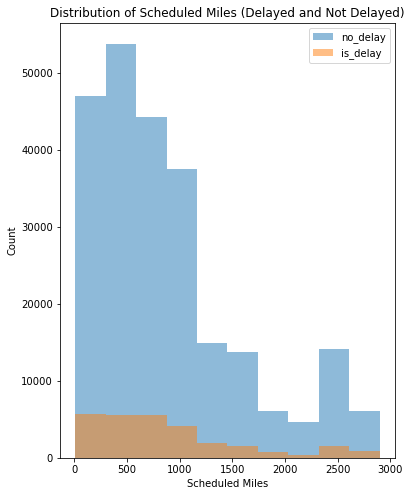

In [50]:
# difference between delayed and not delayed?

fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot()
ax.set_title('Distribution of Scheduled Miles (Delayed and Not Delayed)')
ax.hist(flights.loc[flights.is_delay==-1]['SKD_MILES'], alpha=0.5, label='no_delay')
ax.hist(flights.loc[flights.is_delay==1]['SKD_MILES'], alpha=0.5, label='is_delay')
ax.set_xlabel('Scheduled Miles')
ax.set_ylabel('Count')
plt.legend();

Text(0, 0.5, 'Count')

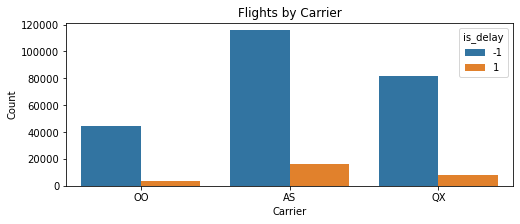

In [51]:
# delayed flights by carriers?

fig = plt.figure(figsize=(8,3))
ax = sns.countplot(x='OPER_CARR_CD', hue='is_delay', data=flights)
ax.set_title('Flights by Carrier')
ax.set_xlabel('Carrier')
ax.set_ylabel('Count')

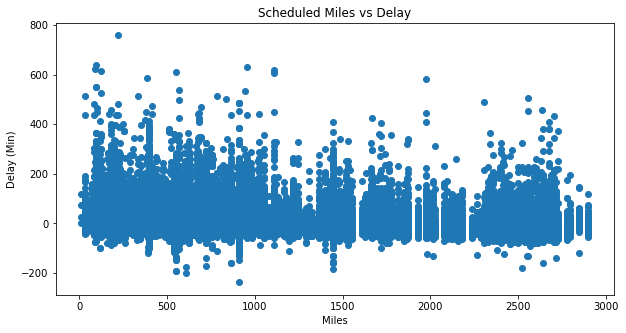

In [52]:
# scheduled miles vs delay?

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.set_title('Scheduled Miles vs Delay')
ax.scatter(x=flights.SKD_MILES, y=flights.delay_min)
ax.set_ylabel('Delay (Min)')
ax.set_xlabel('Miles');

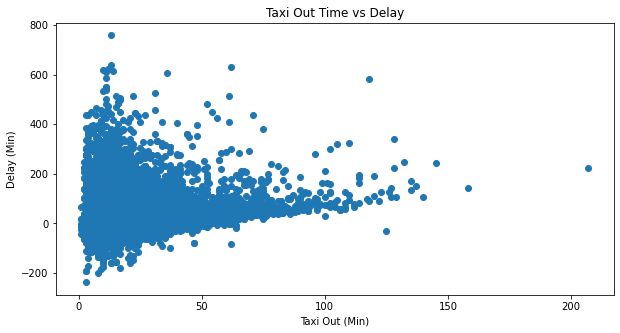

In [53]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.set_title('Taxi Out Time vs Delay')
ax.scatter(x=flights.ACT_TAXI_OUT_MIN, y=flights.delay_min)
ax.set_ylabel('Delay (Min)')
ax.set_xlabel('Taxi Out (Min)');

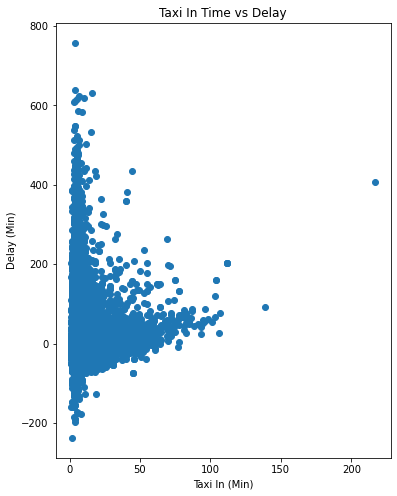

In [54]:
# taxi out time vs delay?

fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot()
ax.set_title('Taxi In Time vs Delay')
ax.scatter(x=flights.ACT_TAXI_IN_MIN, y=flights.delay_min)
ax.set_ylabel('Delay (Min)')
ax.set_xlabel('Taxi In (Min)');

There definitely seems to be a relationship between the taxi time and the actual delay. 

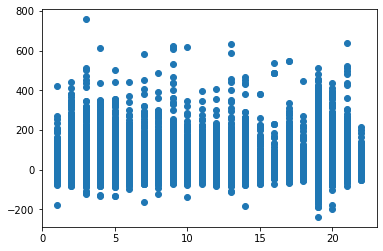

In [55]:
# aircraft age vs delay?

plt.scatter(x=flights.ac_age, y=flights.delay_min)

array([[<AxesSubplot:title={'center':'ac_age'}>]], dtype=object)

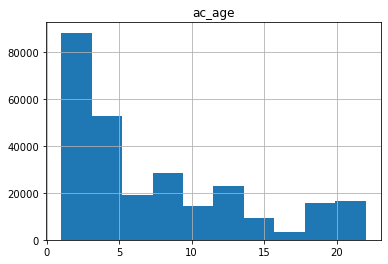

In [56]:
# distribution of aircraft age?

flights.hist('ac_age')

## Step 4: Preprocessing variables <a name="step4"></a>

[(Back to top)](#top)

- Response variable is already defined as the `is_delay` column
- Some of the variables included are not relevant as they are either descriptive (timezone offset) or identifiers (flight number)
- Some of the variables actually point to relevant data, but are incomplete at this stage:
    - I would argue that origin/destination codes are not useful at this stage. Because of the high cardinality, it is difficult to dummify/factorize for each airport code, or at least it decreases the interpretability of the model. However, the location is possibly relevant - flights are often delayed due to the weather, and ideally the location/time combination can be used to retreive weather data. 
- Remaining categorical variables should be onehot encoded (aircraft types, carrier, month)
- The datetime columns are already represented in the `month` category and `is_delay` response, so they should also be dropped.
- Split the x, y variables to train/test sets

In [57]:
# load more libraries

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [58]:
# again- revisit the variables

flights.columns

Index(['OPER_CARR_CD', 'ACT_ORIG', 'ACT_DEST', 'FLT_NBR', 'ACT_FULL_TAIL_NBR',
       'ACT_AC_TYPE', 'SKD_MILES', 'ACT_TAXI_OUT_MIN', 'ACT_TAXI_IN_MIN',
       'SKD_ZULU_DPTR_DTTM', 'ACT_ZULU_DPTR_DTTM', 'SKD_ZULU_ARRV_DTTM',
       'ACT_ZULU_ARRV_DTTM', 'ACT_ORIG_GMT_OFFSET', 'ACT_DEST_GMT_OFFSET',
       'month', 'delay_min', 'is_delay', 'skd_flight_time', 'year_mfr',
       'ac_age'],
      dtype='object')

In [59]:
# drop the unneeded variables

keep_cols = ['OPER_CARR_CD', 
             'ACT_AC_TYPE',
             'SKD_MILES',
             'ACT_TAXI_OUT_MIN',
             'ACT_TAXI_IN_MIN',
             'month',
             'ac_age']

flights_keep = flights[keep_cols].copy()

In [60]:
# categorical variables

print('Aircraft types: ',flights_keep.ACT_AC_TYPE.unique())
print('Carriers: ', flights_keep.OPER_CARR_CD.unique())
print('Months: ', flights_keep.month.unique())

Aircraft types:  ['E175' '737-800' '737-900E' '737-900R' '737-800E' 'A320' 'A319' '737-900'
 'A32B' 'A321' '737-700' '737-700F' 'DH8-400' 'A3SE']
Carriers:  ['OO' 'AS' 'QX']
Months:  ['March' 'October' 'September' 'April' 'February' 'December' 'January'
 'November' 'August' 'June' 'May' 'July']


In [61]:
# encode categorical variables

df_cat = pd.get_dummies(flights_keep[['OPER_CARR_CD', 'ACT_AC_TYPE', 'month']])

x_cat = df_cat.to_numpy()

print('x_cat.shape: ', x_cat.shape)

x_cat.shape:  (269763, 29)


In [62]:
# get the numerical variables

df_num = flights_keep[['SKD_MILES', 'ACT_TAXI_OUT_MIN', 'ac_age']].copy()
x_num = df_num.to_numpy()

print('x_num.shape: ', x_num.shape)

x_num.shape:  (269763, 3)


In [63]:
# combine to get the x array

x = np.concatenate((x_cat, x_num), axis=1)
print('x.shape: ', x.shape)

x.shape:  (269763, 32)


In [64]:
# get the response variable

y = flights['is_delay'].to_numpy()

print('y.shape: ', y.shape)

y.shape:  (269763,)


In [65]:
# get train/test dataset

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=99)

print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (215810, 32)
y_train.shape:  (215810,)
x_test.shape:  (53953, 32)
y_test.shape:  (53953,)


In [66]:
# standardize numerical variables

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.fit_transform(x_test)

print('X_train.mean: ', X_train.mean())
print('X_train.std: ', X_train.std())
print('X_test.mean: ', X_test.mean())
print('X_test.std: ', X_test.std())

X_train.mean:  -1.966078886224546e-18
X_train.std:  0.9999999999995425
X_test.mean:  -2.115376845244307e-18
X_test.std:  0.9999999999999661


## Step 5: Logistic Regression <a name="step5"></a>

[(Back to top)](#top)

This is a classification problem, where we are trying to predict whether the flight will be delayed (`is_delay==1`) or not (`is_delay==-1`). For a simple model, I will use logistic regression to fit a model to the training dataset, and then predict on the test set. 

In [67]:
# load more libraries

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [68]:
# model

m = LogisticRegressionCV(cv=5, class_weight='balanced').fit(X_train, y_train)

In [69]:
m.coef_

array([[ 0.01677141, -0.06770711,  0.03710407,  0.02995039,  0.33202806,
         0.00329311,  0.01079865, -0.00094498, -0.06021481, -0.07543169,
         0.00653741, -0.01616003, -0.01852115, -0.03164191,  0.00270865,
        -0.02100985, -0.00091774, -0.13115472,  0.01649235,  0.00167365,
         0.16069525, -0.04109706, -0.01345226, -0.03014643,  0.05616907,
        -0.08400523,  0.04023945, -0.00629225, -0.04961156, -0.00554201,
         0.38367361,  0.09879057]])

In [70]:
# look at the coefficients

cat_names = df_cat.columns.to_list()
num_names = df_num.columns.to_list()
feature_names = list(np.concatenate([cat_names, num_names]).flat)

pd.DataFrame({'features':feature_names, 'coef':m.coef_.flatten()})

,features,coef
0,OPER_CARR_CD_AS,0.016771
1,OPER_CARR_CD_OO,-0.067707
2,OPER_CARR_CD_QX,0.037104
3,ACT_AC_TYPE_737-700,0.029950
4,ACT_AC_TYPE_737-700F,0.332028
5,ACT_AC_TYPE_737-800,0.003293
6,ACT_AC_TYPE_737-800E,0.010799
7,ACT_AC_TYPE_737-900,-0.000945
8,ACT_AC_TYPE_737-900E,-0.060215
9,ACT_AC_TYPE_737-900R,-0.075432


In [71]:
# test on test set

pred = m.predict(X_test)

In [72]:
# misclassification error

print('misclassification: ', 1-np.mean(y_test==pred))

misclassification:  0.2594480381072415


## Step 6: Model Accuracy <a name="step6"></a>

[(Back to top)](#top)

In the step above, I computed the model misclassification rate, but next will compute the confusion matrix

In [73]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [74]:
# confusion matrix as percent

confusion_matrix(y_test, pred)/y_test.shape[0]

array([[0.68454025, 0.21097993],
       [0.04846811, 0.05601171]])

In [75]:
# confusion matrix

confusion_matrix(y_test, pred)

array([[36933, 11383],
       [ 2615,  3022]], dtype=int64)

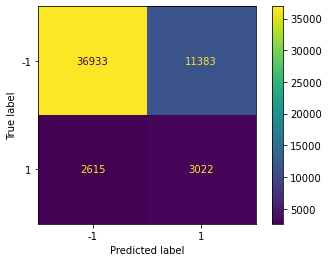

In [76]:
# plotting confusion matrix

plot_confusion_matrix(m, X_test, y_test)

In [77]:
def precision(y_true, y_pred):
    tp, fp, tn, fn = confusion_matrix(y_true, y_pred).ravel()
    
    return tp/(tp + fp)

def recall(y_true, y_pred):
    tp, fp, tn, fn = confusion_matrix(y_true, y_pred).ravel()
    
    return tp/(tp + fn)

def f1(y_true, y_pred):
    
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    
    return 2*prec*rec/(prec+rec)

In [78]:
print('precision: ',precision(y_test, pred))
print('recall: ', recall(y_test, pred))
print('f1: ', f1(y_test, pred))

precision:  0.7644051659905622
recall:  0.9243649105243399
f1:  0.836809371141145


## Step 7: Iterations <a name="step7"></a>

[(Back to top)](#top)

In order to iterate through various combination of variables, I will set up a function below which can take column names of the variables as parameters to generate the training and testing sets.

In [79]:
# load more libraries

import time

In [80]:
def get_std_train_test_sets(df, cat_cols, num_cols, response):
    """
    Helper function 
    Get training/testing sets given variables and standardize
    df: pandas DataFrame
    cat_cols: list, categorical variable column names
    num_cols: list, numerical variable column names
    response: string, column name of the response variable
    Returns: training/testing sets for X and Y
    """
    
    # categorical variables
    df_cat = pd.get_dummies(df[cat_cols].copy())
    x_cat = df_cat.to_numpy()
    
    # numerical variables
    df_num = df[num_cols].copy()
    x_num = df_num.to_numpy()
    
    # combine cat and num variables
    x = np.concatenate((x_cat, x_num), axis=1)
    
    # get response variable
    y = df[response].to_numpy()

    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=99)
    
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(x_train)
    X_test = scaler.fit_transform(x_test)

    return X_train, X_test, y_train, y_test

In [81]:
def get_model_perf(m, X_test, y_test):
    
    pred = m.predict(X_test)
    misclass = 1-np.mean(y_test==pred)
    tp, fp, tn, fn = confusion_matrix(y_test, pred).ravel()
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1 = (2 * precision * recall)/(precision + recall)
    
    print('misclassification: ', misclass)
    print('---------------')
    print('precision: ', precision)
    print('recall: ', recall)
    print('f1: ', f1)

In [82]:
def logistic_regression(df, cat_cols, num_cols, response, balanced=True):
    """
    Function to run through the entire workflow
    """
    start = time.time()
    X_train, X_test, y_train, y_test = get_std_train_test_sets(df, cat_cols, num_cols, response)
    print('X_train.shape: ', X_train.shape)
    print('y_train.shape: ', y_train.shape)
    print('X_test.shape: ', X_test.shape)
    print('y_test.shape: ', y_test.shape)
    print('---------------')
    
    if balanced:
        m = LogisticRegressionCV(cv=5, class_weight='balanced', random_state=1).fit(X_train, y_train)
    else:
        m = LogisticRegressionCV(cv=5, random_state=1).fit(X_train, y_train)
    get_model_perf(m, X_test, y_test)
    print('---------------')
    print('Confusion Matrix (as % of total)')
    
    pred = m.predict(X_test)
    print(confusion_matrix(y_test, pred)/y_test.shape[0])
    
    plot_confusion_matrix(m, X_test, y_test);
    
    end = time.time()
    
    print('---------------')
    print('time took: ', end-start)
    
    return m.coef_

In [83]:
# revisiting again

flights.columns

Index(['OPER_CARR_CD', 'ACT_ORIG', 'ACT_DEST', 'FLT_NBR', 'ACT_FULL_TAIL_NBR',
       'ACT_AC_TYPE', 'SKD_MILES', 'ACT_TAXI_OUT_MIN', 'ACT_TAXI_IN_MIN',
       'SKD_ZULU_DPTR_DTTM', 'ACT_ZULU_DPTR_DTTM', 'SKD_ZULU_ARRV_DTTM',
       'ACT_ZULU_ARRV_DTTM', 'ACT_ORIG_GMT_OFFSET', 'ACT_DEST_GMT_OFFSET',
       'month', 'delay_min', 'is_delay', 'skd_flight_time', 'year_mfr',
       'ac_age'],
      dtype='object')

In [84]:
# repeat Step 4 in single step

cat_cols = ['OPER_CARR_CD', 'ACT_AC_TYPE', 'month']
num_cols = ['SKD_MILES', 'ACT_TAXI_OUT_MIN', 'ac_age']

iteration 1: 
---------------
X_train.shape:  (215810, 32)
y_train.shape:  (215810,)
X_test.shape:  (53953, 32)
y_test.shape:  (53953,)
---------------
misclassification:  0.2594480381072415
---------------
precision:  0.7644051659905622
recall:  0.9243649105243399
f1:  0.836809371141145
---------------
Confusion Matrix (as % of total)
[[0.68454025 0.21097993]
 [0.04846811 0.05601171]]
---------------
time took:  9.130955934524536


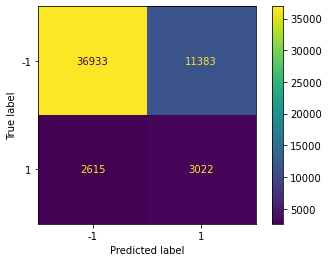

In [85]:
print('iteration 1: ')
print('---------------')
iter1 = logistic_regression(flights, cat_cols, num_cols, 'is_delay')

In [86]:
# this time include high cardinality orig/dest airport codes as dummies

cat_cols_airport = ['OPER_CARR_CD', 'ACT_ORIG', 'ACT_DEST', 'ACT_AC_TYPE', 'month']
num_cols = ['SKD_MILES', 'ACT_TAXI_OUT_MIN', 'ac_age']

iteration 2: 
---------------
X_train.shape:  (215810, 278)
y_train.shape:  (215810,)
X_test.shape:  (53953, 278)
y_test.shape:  (53953,)
---------------
misclassification:  0.2500139009878969
---------------
precision:  0.7701589535557579
recall:  0.9196075523922499
f1:  0.8382743861230008
---------------
Confusion Matrix (as % of total)
[[0.68969288 0.20582729]
 [0.04418661 0.06029322]]
---------------
time took:  38.844534397125244


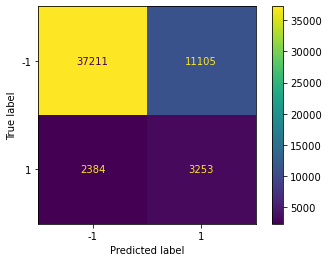

In [87]:
print('iteration 2: ')
print('---------------')
betas = logistic_regression(flights, cat_cols_airport, num_cols, 'is_delay')

## Conclusion <a name="conclusion"></a>

[(Back to top)](#top)

The purpose of this exercise was to find a way to predict whether a flight would be delayed or not- a potential delay can be mitigated by asking the crew to fly faster, but doing so increases fuel costs, so correctly classifying the outcomes is important. On the flip side, missing the incorrectly labeled non-delay flights would decrease Alaska Airlines' on-time performance.  

- True delay (correctly classifies delayed flights): majority of the true delays were correctly classified (58% of all actual delays are classified correctly)
    - Business implication: Delays are potentially mitigated, fuel costs are appropriately allocated
- True non delay (correctly classifies on-time flights): majority of the true non delays were correctly classified (77% of alll actual on-times are classified correctly)  
    - Business implication: Flight is on-time, and no actions were needed, no actions taken
- False delay (incorrectly classifies on-time flights): 20% of all flights are assumed to be delayed, but are actually on-time
    - Business implication: Flight is on-time but direction issued to mitigate potential delay- additional fuel costs incurred, flight arrives early
- False on-time (incorrectly classifies delayed flights): 4% of all flights are assumed to be on-time, but are actually delayed
    - Business implication: Flight is delayed but no directions issued to mitigate delay- no fuel costs incurred but flight delayed, decreases on-time performance  
    
This model may be improved by additional relevant variables, such as weather, wind speed at the origin and destination airports, or during the flight path. Models other than logistic regression can also be explored. 